In [1]:
import warnings
from statistics import mean

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib import pyplot
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# 1. Data Preprocessing

<h2>1.1 Loading Dataset <h2>

In [2]:
# Read the csv file
df_train = pd.read_csv("D:/Backorder Prediction/backorder-prediction/test_dataset/Kaggle_Training_Dataset_v2.csv")
df_test = pd.read_csv("D:/Backorder Prediction/backorder-prediction/test_dataset/Kaggle_Test_Dataset_v2.csv")


In [3]:
df_train.tail()


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,...,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,...,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,...,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,...,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_test.tail()


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,...,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242075,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Dropping the last record which contains NaN

In [5]:
# Dropping last record of train and test dataset
df_train = df_train[:-1]
df_test = df_test[:-1]


# 2. Feature Engineering

## 2.1 Converting  Boolean values to Binary values 

In [6]:
# Encode categorical columns with values Yes and No to 1 and 0 respectively
def encode_bool(df):
    # Creating dictionary with mapping values
    dict_map_bool = {'Yes': 1.0, 'No': 0.0}

    df['deck_risk'] = df['deck_risk'].map(dict_map_bool)
    df['potential_issue'] = df['potential_issue'].map(dict_map_bool)
    df['oe_constraint'] = df['oe_constraint'].map(dict_map_bool)
    df['ppap_risk'] = df['ppap_risk'].map(dict_map_bool)
    df['stop_auto_buy'] = df['stop_auto_buy'].map(dict_map_bool)
    df['rev_stop'] = df['rev_stop'].map(dict_map_bool)
    df['went_on_backorder'] = df['went_on_backorder'].map(dict_map_bool)

    return df


df_train = encode_bool(df_train)
df_test = encode_bool(df_test)


In [7]:
df_test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 2.2 Replacing unknown values

In [8]:
# Replacing -99 in perfomance columns with nan

def replace_unknown(df):
    df.perf_6_month_avg.replace({-99.0: np.nan}, inplace=True)
    df.perf_12_month_avg.replace({-99.0: np.nan}, inplace=True)

    return df


df_train = replace_unknown(df_train)
df_test = replace_unknown(df_test)


In [9]:
df_train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## 2.3 Handling missing values

In [10]:
X_train_iter = df_train.copy()
X_test_iter = df_test.copy()


In [11]:
# Using Iterative Imputer method to replace missing values

iter = IterativeImputer(max_iter=10, random_state=0)
iter.fit(X_train_iter)
X_train_iter[:] = iter.transform(X_train_iter)
X_test_iter[:] = iter.transform(X_test_iter)


## 2.4 Correlation of numerical features with target variable

In [12]:
# Numerical columns list
num_col_list = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month',
                'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
                'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


In [13]:
# Correlation using Point Biserial correlation
y_train = df_train['went_on_backorder']


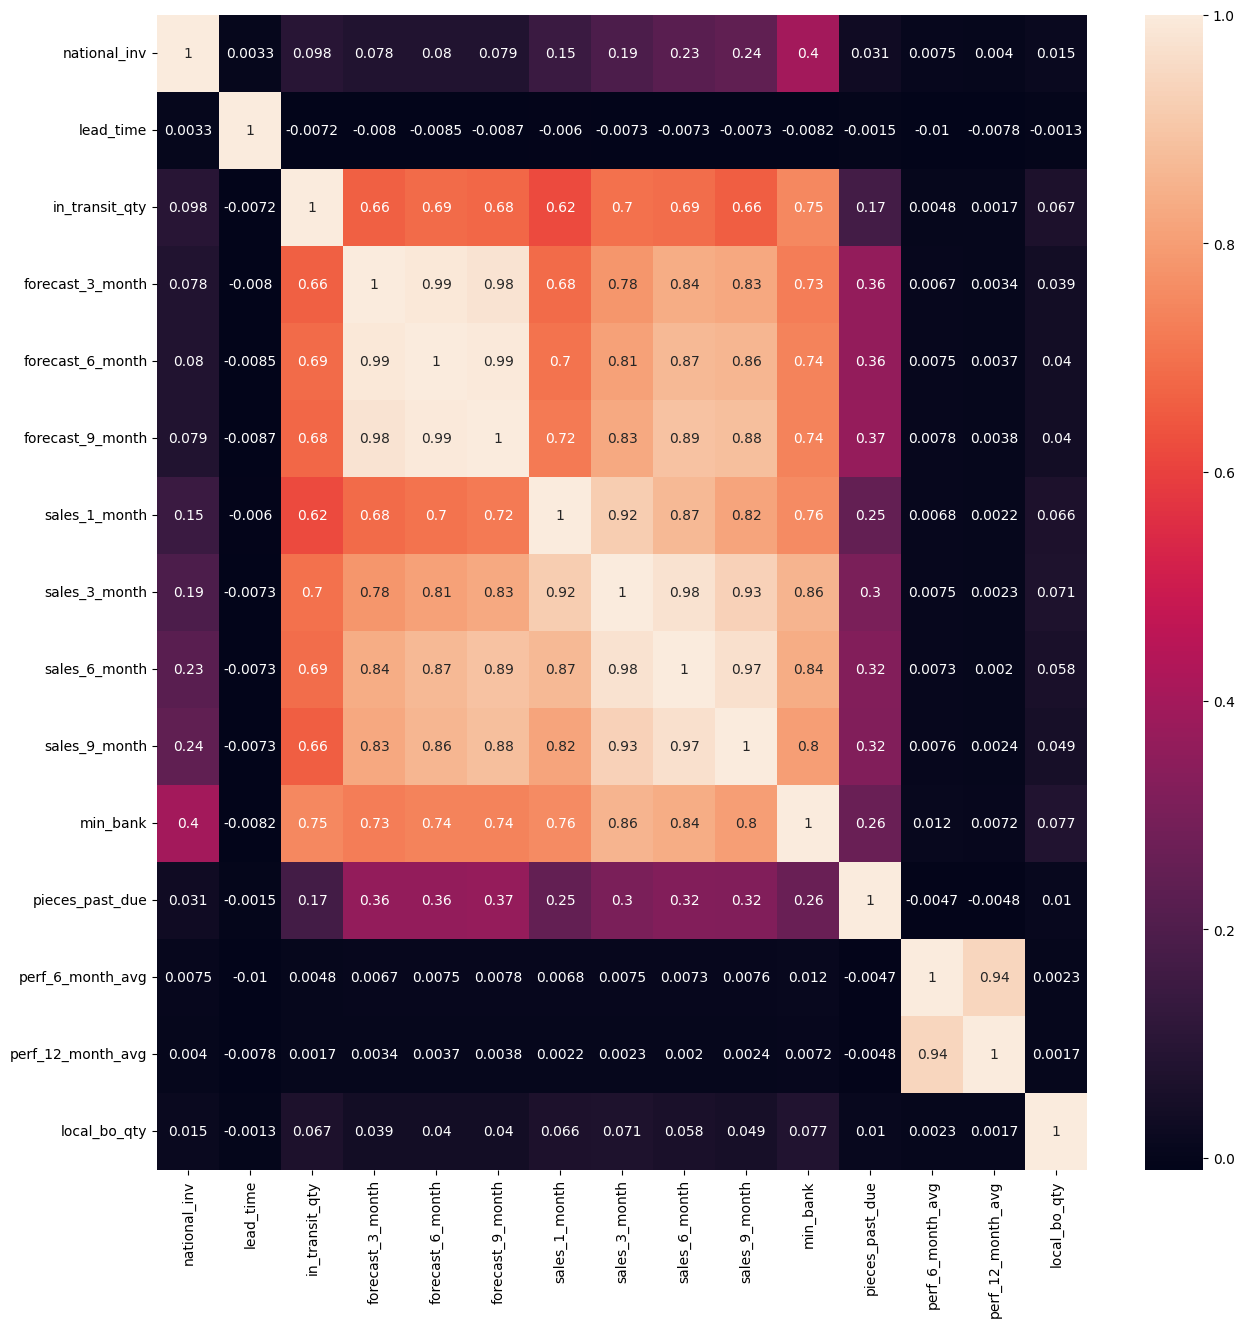

In [14]:
# Subset dataframe to only keep columns in the list
df_num_col = df_train[num_col_list]

# Generate heatmap
fig, ax = plt.subplots(figsize=(15, 15), facecolor='none')
sns.heatmap(df_num_col.corr(), annot=True)
fig.set_facecolor('none')
plt.savefig('images/heatmap.png')
plt.show()


* Based on the data analysis, it was discovered that the columns related to performance demonstrated the highest correlation with the target variable.
* In addition to the performance columns, the lead_time feature also displayed some degree of correlation with the target variable.
* On the other hand, the other columns in the dataset did not exhibit substantial correlation with the target variable.
* Notably, only two features, namely local_bo_qty and pieces_past_due, demonstrated a positive correlation with the target variable.


## 2.5 Raw Data features Visualization Before Transformations

In [15]:
df_train_num_untrans = df_train.copy()
df_train_num_untrans = df_train_num_untrans.drop(
    ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'], axis=1)


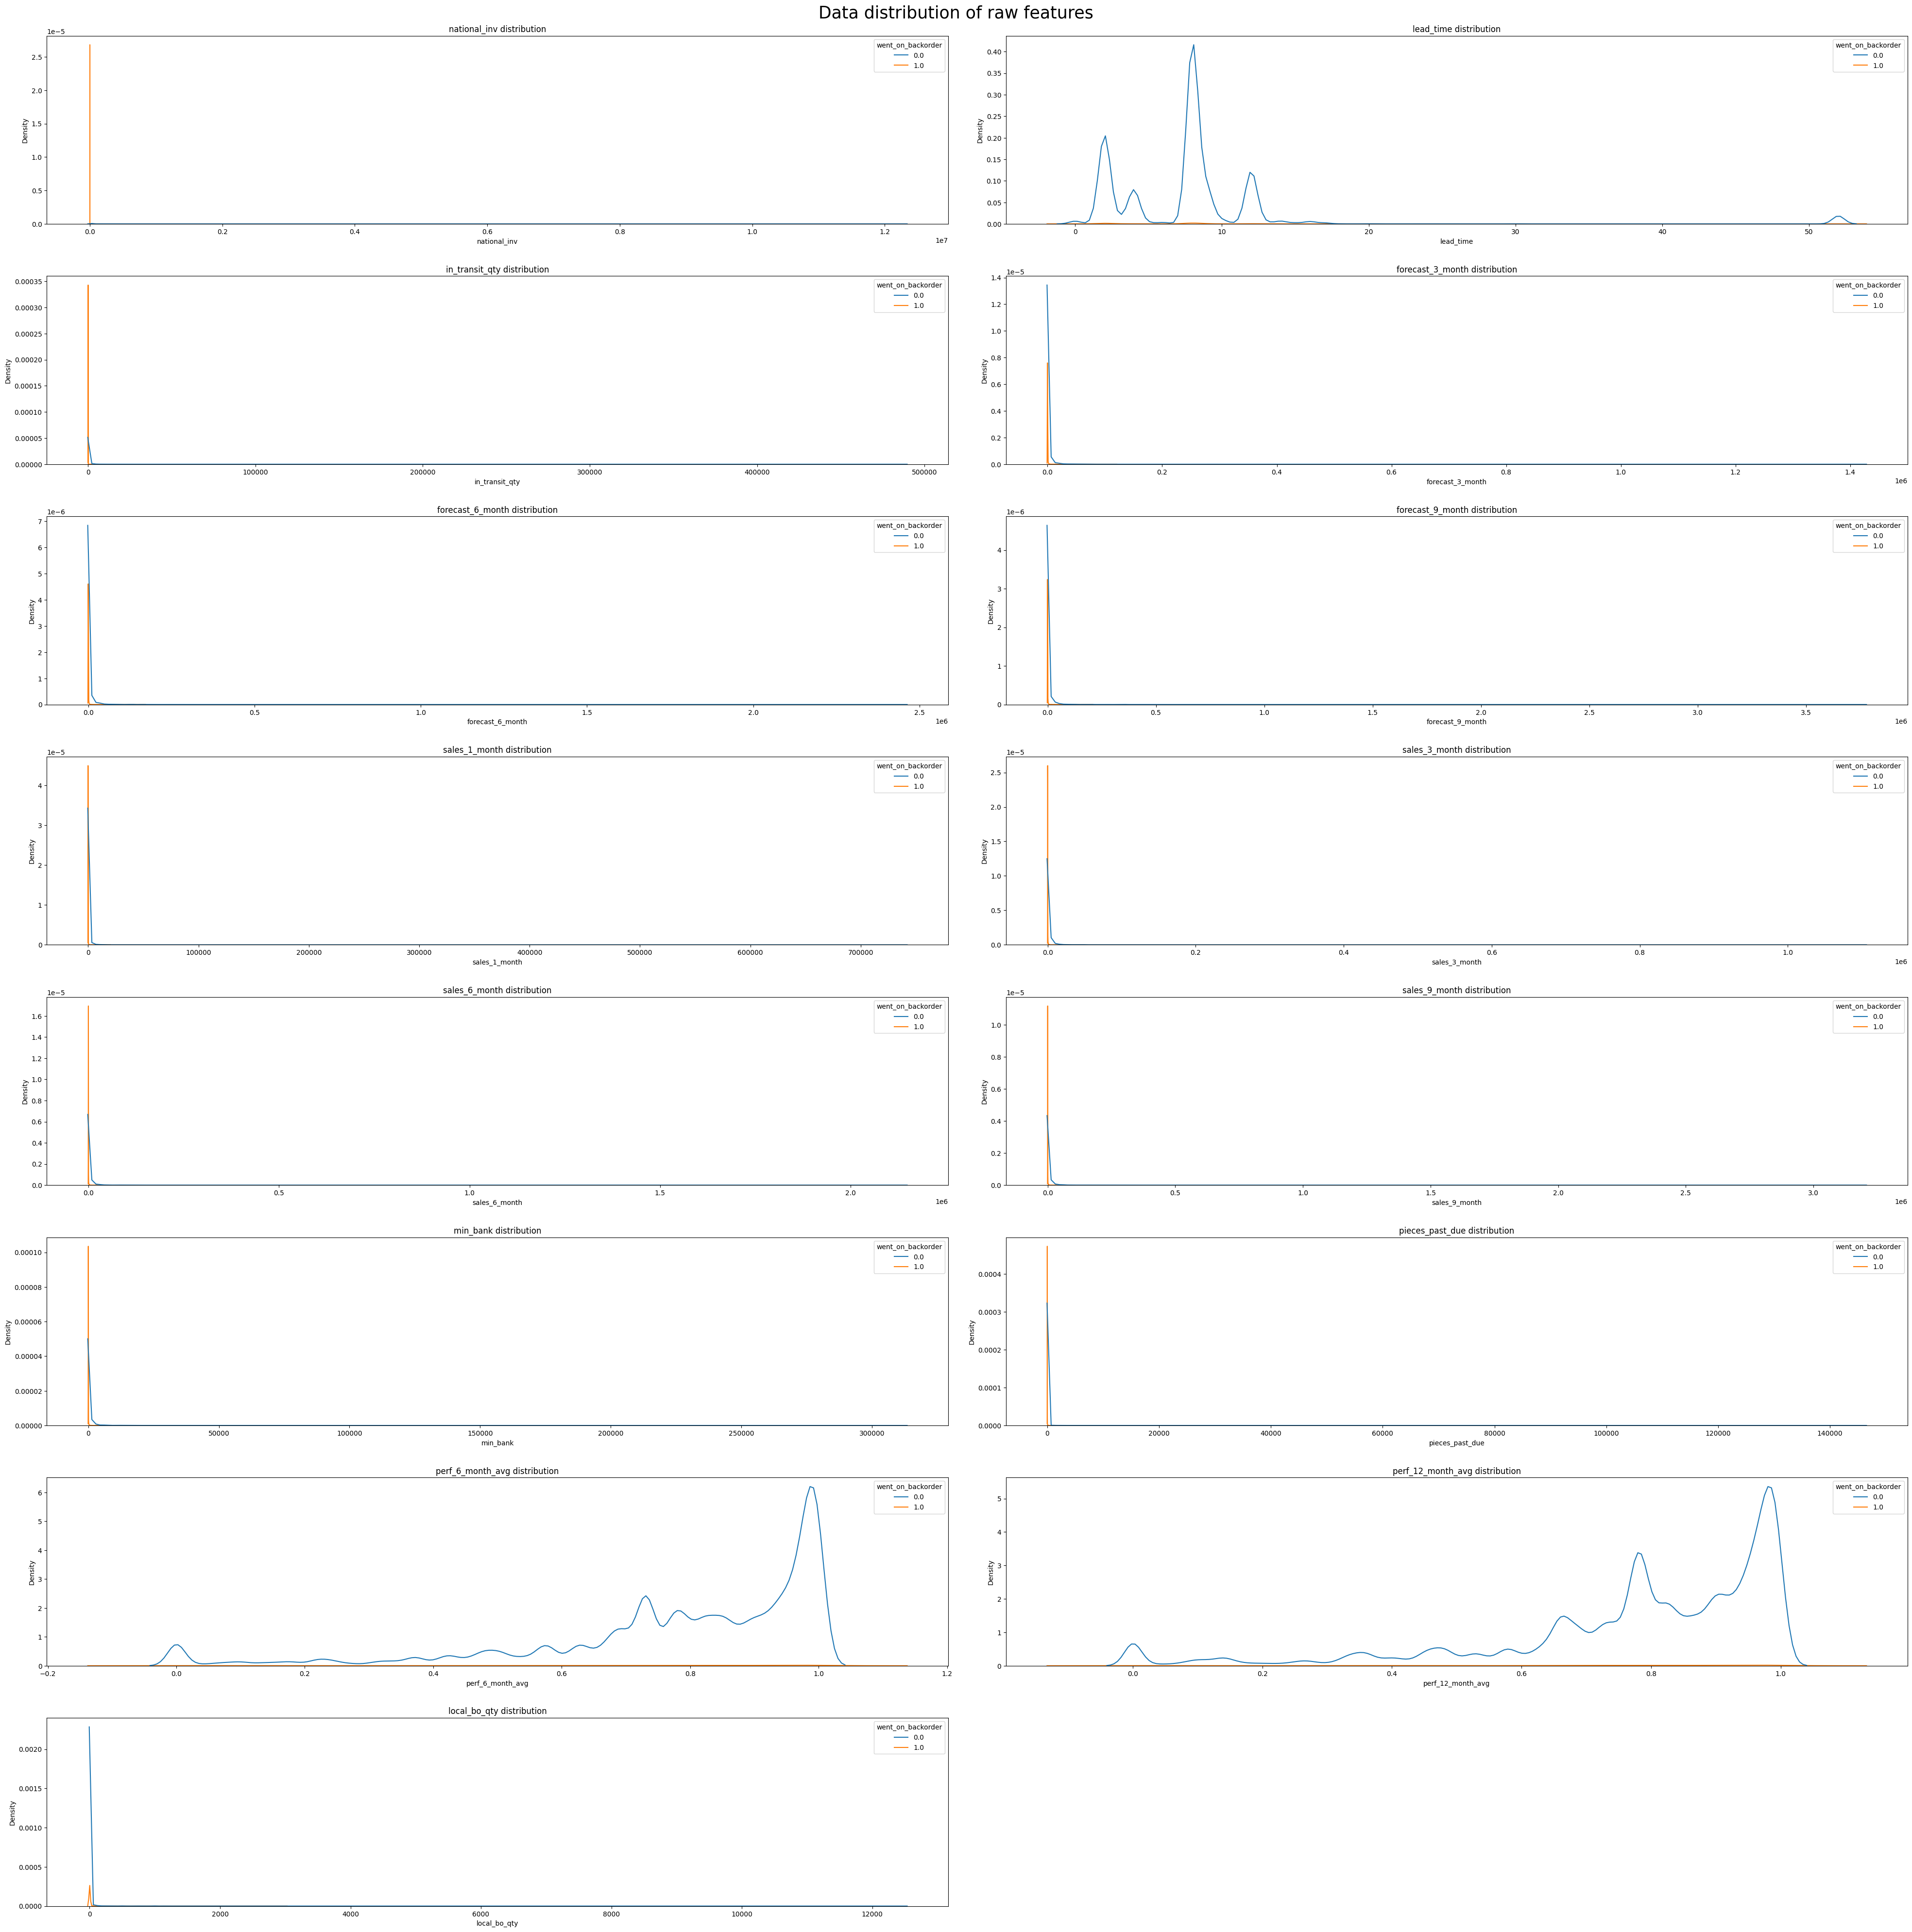

In [16]:
# Distribution of raw features before transformations
fig = plt.figure(figsize=(40, 40), facecolor='None')
for idx, val in enumerate(df_train_num_untrans.drop(['went_on_backorder'], axis=1)):
    ax1 = fig.add_subplot(8, 2, idx + 1)
    ax1.title.set_text(val + ' distribution')
    sns.kdeplot(data=df_train_num_untrans, x=val, hue='went_on_backorder')

fig.tight_layout(pad=3.0)
fig.suptitle("Data distribution of raw features", fontsize=25, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/raw_features.png')
plt.show()


* It is difficult to seperate out the classes in these features as they are high overlapping

## 2.6 Transformed Features Visualization

In [17]:
X_train_iter_stand = X_train_iter.copy()
X_test_iter_stand = X_test_iter.copy()


In [18]:
# Applying Standard Scaler

sc = StandardScaler().fit(X_train_iter_stand[num_col_list].values)
X_tr_sc_num_feat = sc.transform(X_train_iter_stand[num_col_list].values)
X_te_sc_num_feat = sc.transform(X_test_iter_stand[num_col_list].values)

X_tr_sc_num_feat = pd.DataFrame(
    X_tr_sc_num_feat, index=X_train_iter_stand.index, columns=num_col_list)
X_te_sc_num_feat = pd.DataFrame(
    X_te_sc_num_feat, index=X_test_iter_stand.index, columns=num_col_list)


In [19]:
# Assigning numerical columns to original dataframe
for i in num_col_list:
    X_train_iter_stand[i] = X_tr_sc_num_feat[i]
    X_test_iter_stand[i] = X_te_sc_num_feat[i]


In [20]:
# Random Undersample the dataset to balance the data

undersample = RandomUnderSampler()
X_train_iter_under, y_train_iter_under = undersample.fit_resample(
    X_train_iter_stand, y_train)


In [21]:
# Creating undersampled dataframes for train set

X_train_iter_under = pd.DataFrame(
    X_train_iter_under, columns=X_train_iter_stand.columns)
y_train_iter_under = pd.DataFrame(
    y_train_iter_under, columns=['went_on_backorder'])


In [22]:
# Creating dataframes with numerical features for train and test set
def create_num_feature(df):
    return df.drop(
        columns=['sku', 'potential_issue', 'deck_risk',
                 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'],
        axis=1
    )


X_train_iter_under_num = create_num_feature(X_train_iter_under)
X_test_iter_num = create_num_feature(X_test_iter_stand)


## 2.7 Creating New Transformed features

In [23]:
# Function to fit logistic regression model
def model(df_final, y):
    log_reg = LogisticRegression()
    log_reg.fit(df_final, y)
    return log_reg


# Function to perform addition of features
def add(df, num_cols):
    for i in num_cols:
        for j in num_cols:
            if (i != j):
                df[i + '_' + j + '_add'] = df[i] + df[j]
    return df


# Function to perform multiplication of features
def mult(df, num_cols):
    for i in num_cols:
        for j in num_cols:
            if (i != j):
                df[i + '_' + j + '_mult'] = df[i] * df[j]
    return df


# Function to perform inverse of features
def inv(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'inv'] = 1 / (df[i] + 0.001)

    return df


# Function to perform square of features
def square(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'square'] = df[i] * df[i]
    return df


# Function to perform square root of features
def sqrt(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'square_root'] = np.sqrt(abs(df[i]))
    return df


# Function to perform log of features
def log(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'log'] = (np.log(abs(df[i]) + 1))
    return df


In [24]:
def apply_transform(df_iter_num, num_col_list):
    df = add(df_iter_num, num_col_list)
    df = mult(df, num_col_list)
    df = inv(df, num_col_list)
    df = square(df, num_col_list)
    df = sqrt(df, num_col_list)
    df = log(df, num_col_list)
    return df


X_train_iter_trans = apply_transform(X_train_iter_under_num, num_col_list)
X_test_iter_trans = apply_transform(X_test_iter_num, num_col_list)


In [25]:
y_train_iter_trans = X_train_iter_trans['went_on_backorder'].values
y_test_iter_trans = X_test_iter_trans['went_on_backorder'].values

X_train_iter_trans = X_train_iter_trans.drop(['went_on_backorder'], axis=1)
X_test_iter_trans = X_test_iter_trans.drop(['went_on_backorder'], axis=1)

# applying logistic regression
model = model(X_train_iter_trans, y_train_iter_trans)
importances = model.coef_
abs_imp = np.abs(importances[0])

# get the sorting indices
sorted_idx = (-abs_imp).argsort()


In [26]:
# print top 20 most important columns
for i in sorted_idx[:20]:
    print(X_train_iter_trans.columns[i])


local_bo_qty_inv
lead_time_inv
pieces_past_due_inv
in_transit_qty_inv
sales_6_month_inv
perf_6_month_avg_inv
perf_6_month_avg_square
perf_12_month_avg_square
perf_12_month_avg_perf_6_month_avg_mult
perf_6_month_avg_perf_12_month_avg_mult
perf_12_month_avg_perf_6_month_avg_add
perf_6_month_avg_perf_12_month_avg_add
perf_12_month_avg_lead_time_add
lead_time_perf_12_month_avg_add
lead_time_perf_6_month_avg_add
perf_6_month_avg_lead_time_add
lead_time_square
in_transit_qty_perf_12_month_avg_add
perf_12_month_avg_in_transit_qty_add
in_transit_qty_perf_6_month_avg_add


In [27]:
X_train_iter_trans_plt = X_train_iter_trans.copy()
X_train_iter_trans_plt['went_on_backorder'] = y_train_iter_trans


### 2.8 Plot of original and transformed features

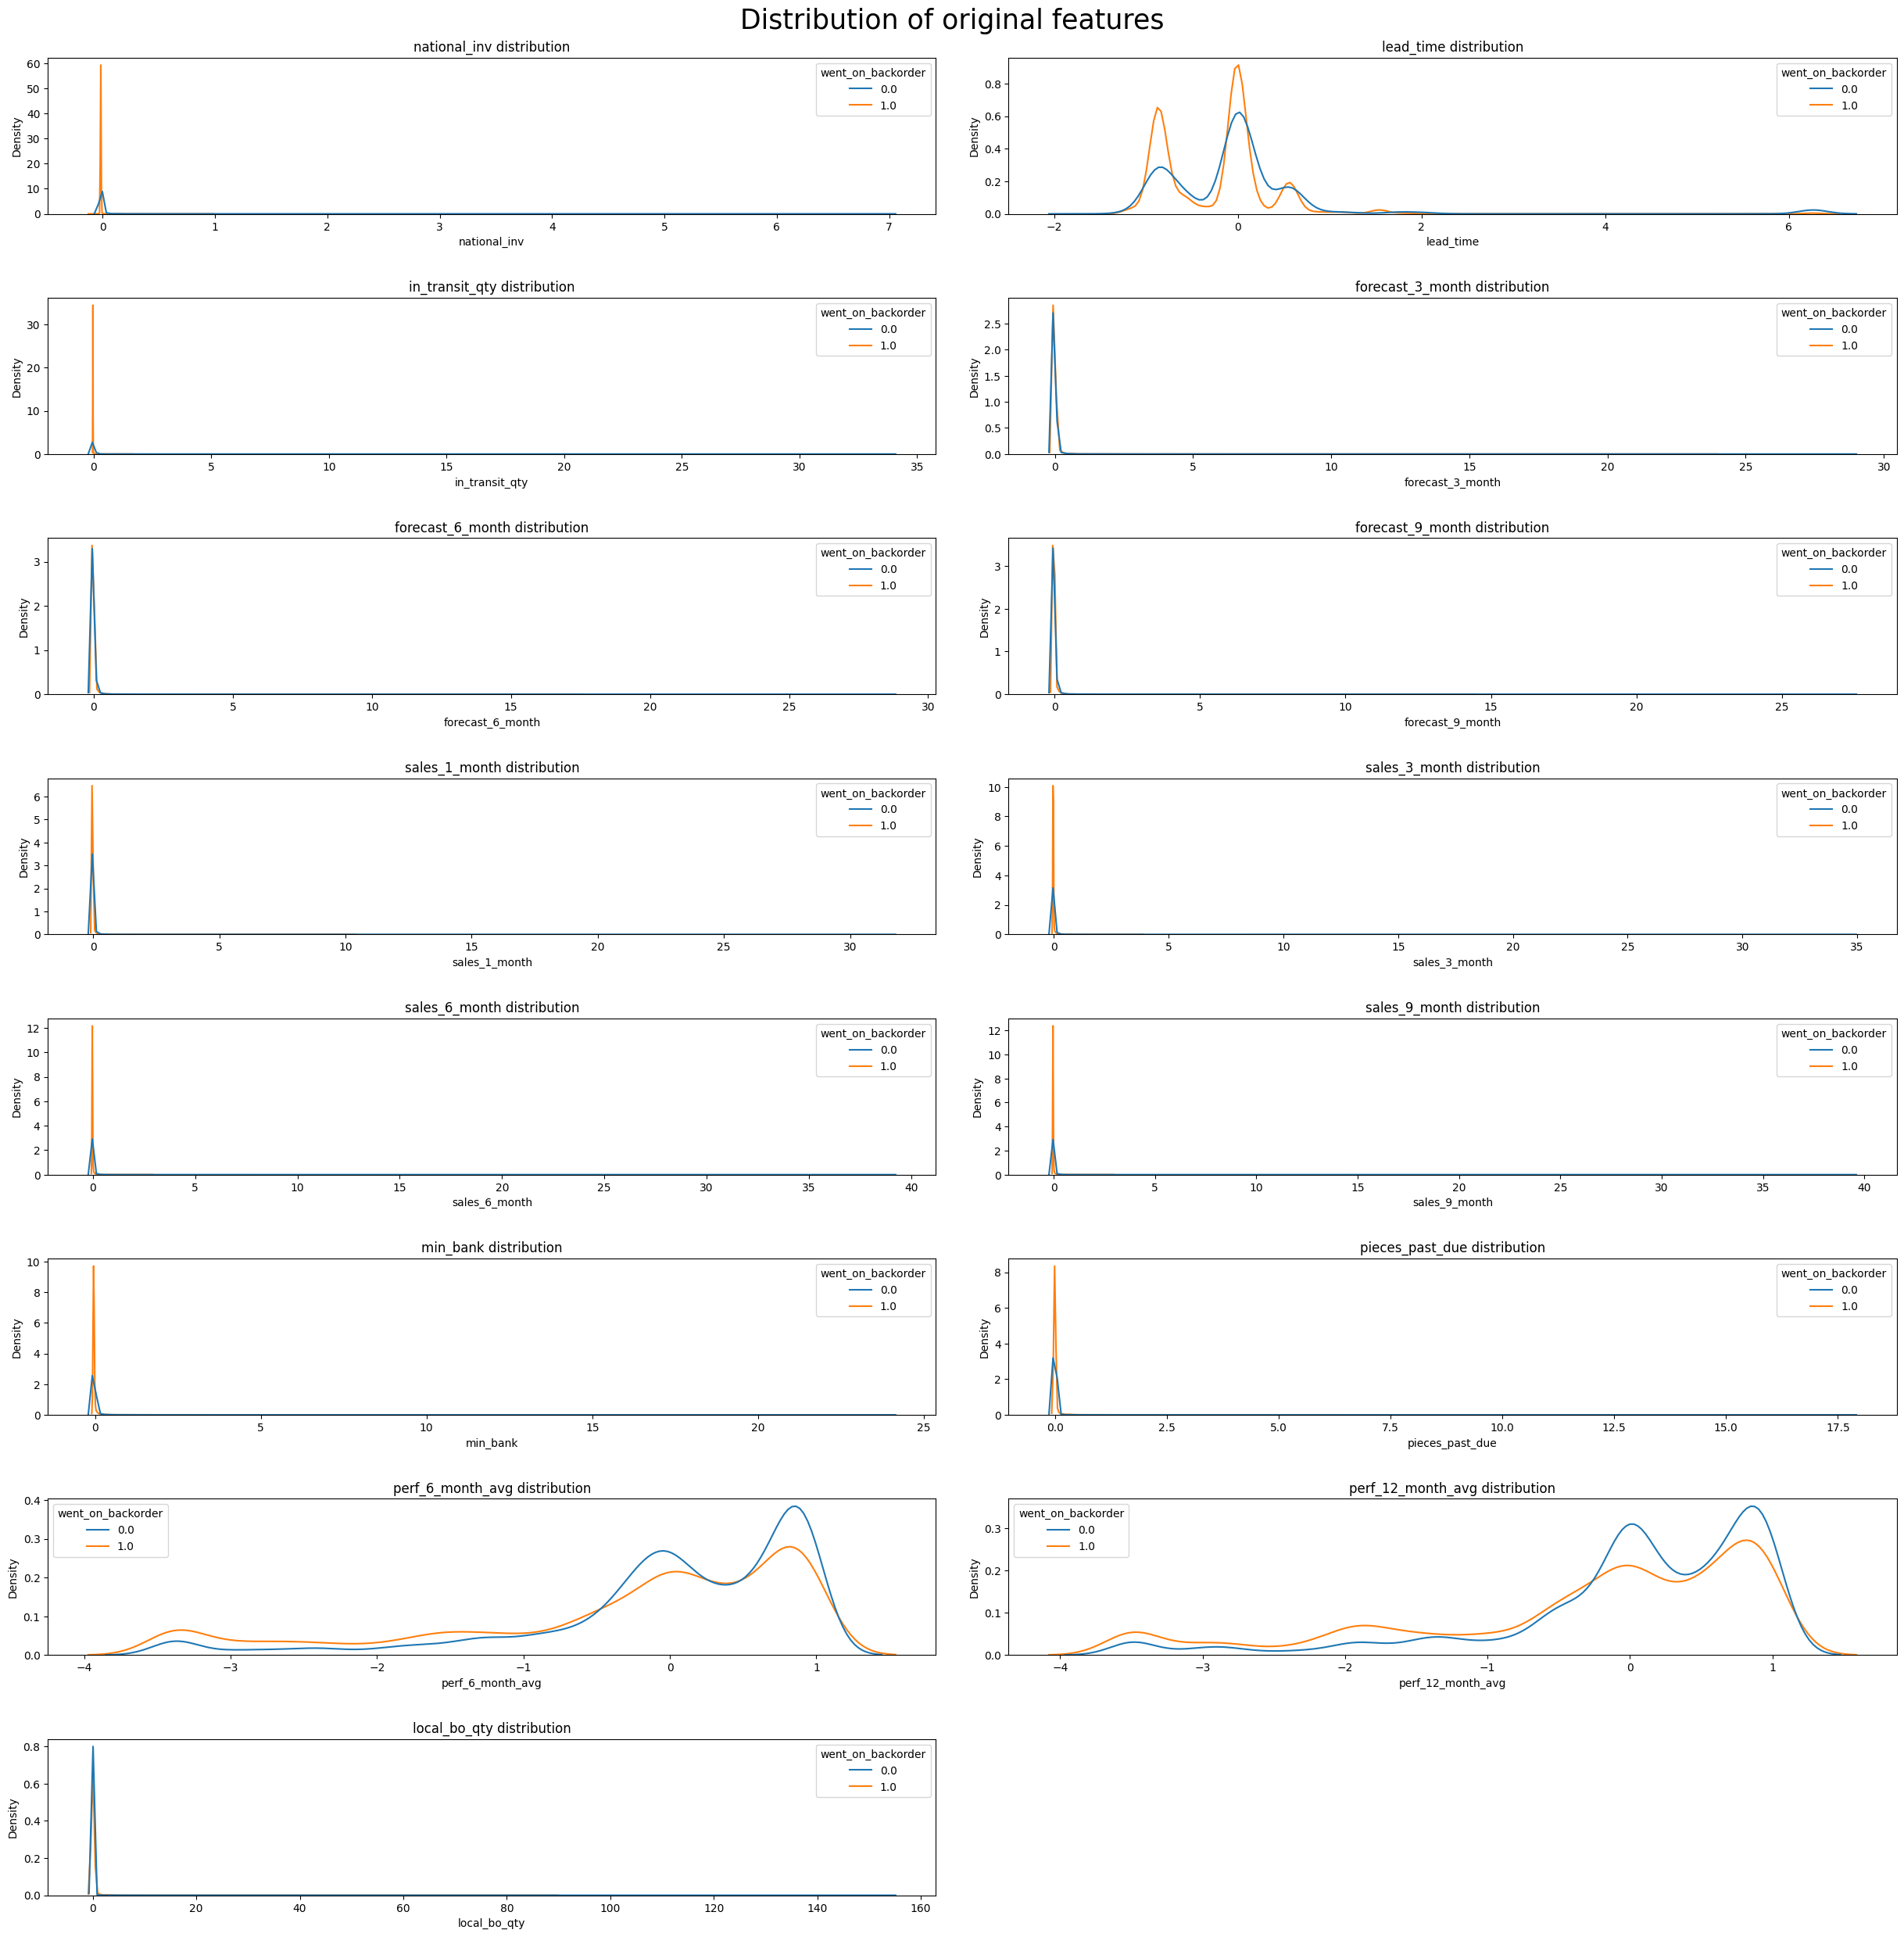

In [28]:
# Distribution of original features
fig = plt.figure(figsize=(25, 25))
for i, j in enumerate(num_col_list):
    ax1 = fig.add_subplot(8, 2, i + 1)
    p = X_train_iter_trans[j]
    ax1.title.set_text(j + ' distribution')
    sns.kdeplot(data=X_train_iter_trans_plt,
                x=num_col_list[i], hue='went_on_backorder')

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of original features", fontsize=25, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/original_after_trans.png')
plt.show()


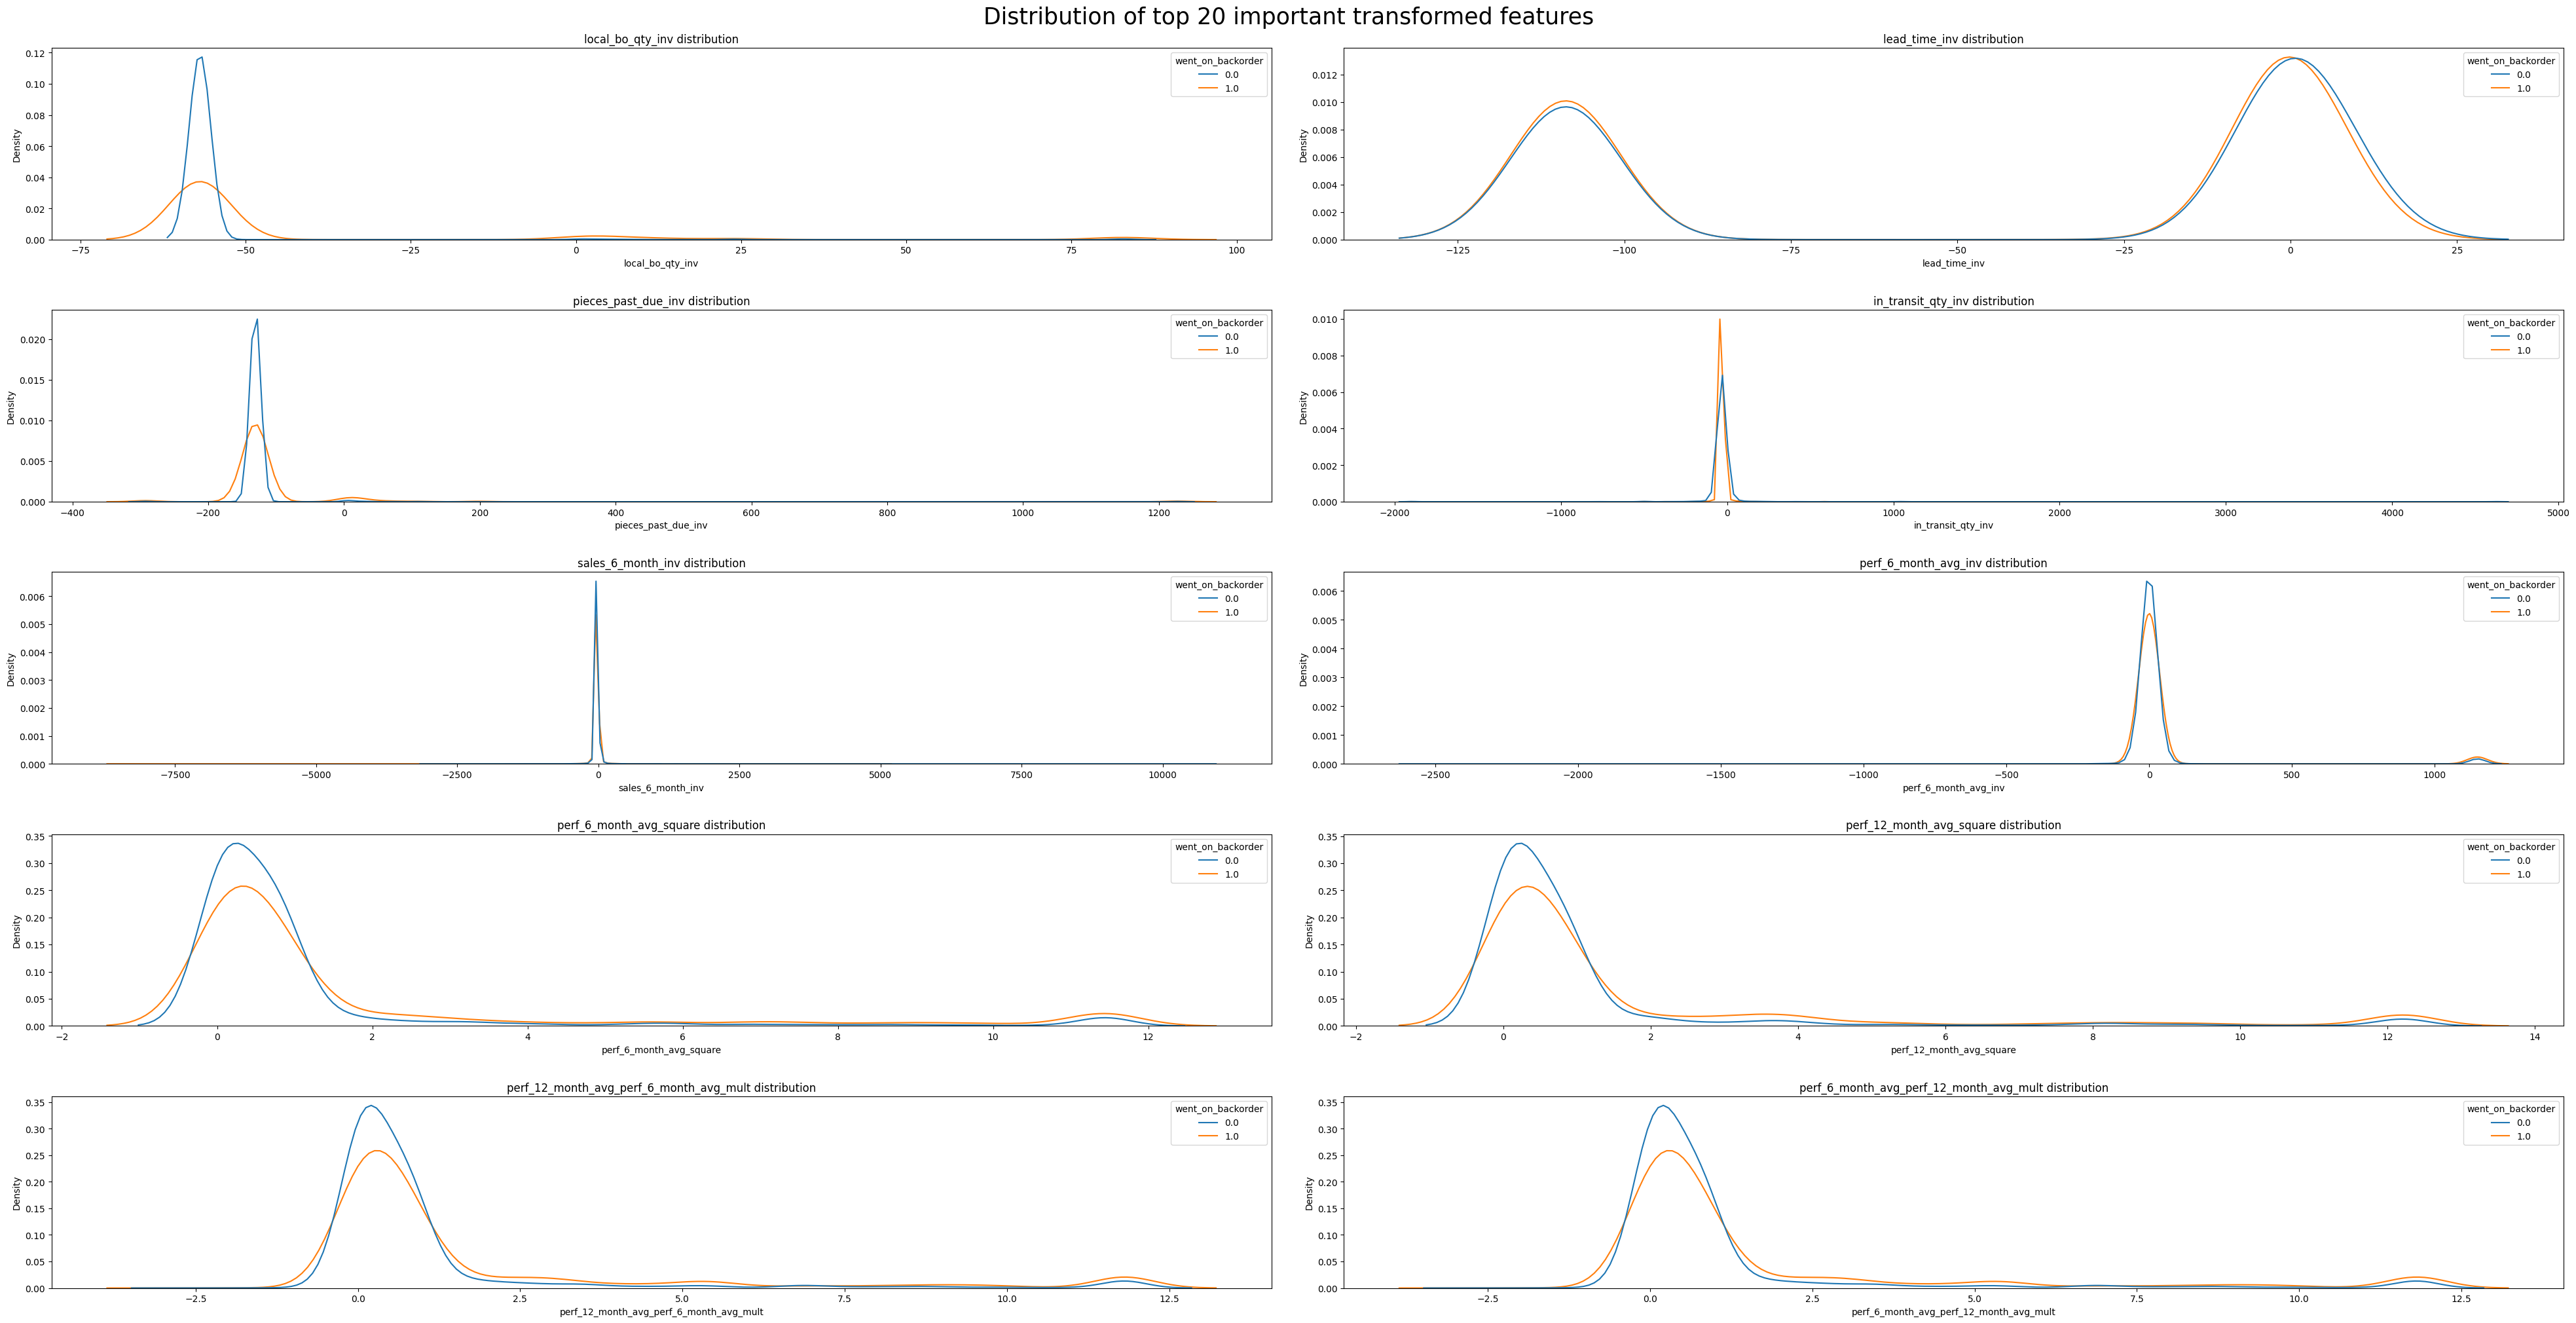

In [29]:
# Distribution of  newly created tranformed features
fig = plt.figure(figsize=(40, 40))
for i, j in enumerate(sorted_idx[:10]):
    ax1 = fig.add_subplot(10, 2, i + 1)
    ax1.title.set_text(X_train_iter_trans_plt.columns[j] + ' distribution')
    sns.kdeplot(data=X_train_iter_trans_plt,
                x=X_train_iter_trans_plt.columns[j], hue='went_on_backorder')

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of top 20 important transformed features",
             fontsize=25, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/top_features.png')
plt.show()


* These newly created features are less skewed and  we are able to see some seperation between positve and negative points which will be helpful in classification

## 2.9 Recursive Feature Selection can be used to choose the most suitable features 

In [30]:
# Assigning remaning columns to train and test data

for cols in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']:
    X_train_iter_trans[cols] = X_train_iter_under[cols]
    X_test_iter_trans[cols] = X_test_iter_stand[cols]


In [31]:
def best_feat(X_train, X_test, y_train, y_test, num_folds=4):
    roc_score = 1
    imp_cols = set()
    train_data = X_train
    target_train_data = y_train
    test_data = X_test
    target_test_data = y_test
    cols_list = list(train_data.columns)
    imp_cols_list = list(imp_cols)
    iter = 1

    while (roc_score > 0.8) & (len(imp_cols_list) != len(cols_list)):

        # Performing K-folds split
        train_data_rem = train_data[train_data.columns[~train_data.columns.isin(
            imp_cols_list)]]
        Kfold = StratifiedKFold(
            n_splits=num_folds, shuffle=True, random_state=33)
        splits = Kfold.split(train_data_rem, target_train_data)
        model_feature_importance = np.zeros_like(train_data_rem.columns)
        roc_scores = []

        print(f"Iteration - {iter}")
        print('*' * 20)

        # Performing K-Fold Cross validation
        for fold_num, (train_idx, val_idx) in enumerate(splits, 1):
            print(f"Fold - {fold_num}")

            # defining the train and validation data
            x_train = train_data_rem.iloc[train_idx]
            x_val = train_data_rem.iloc[val_idx]
            y_train = target_train_data.iloc[train_idx]
            y_val = target_train_data.iloc[val_idx]

            # Implementing the XGB Classifier
            xg = XGBClassifier(n_jobs=-1, random_state=33)
            xg.fit(x_train, y_train)

            # Adding the feature importance of each feature averaged over different folds
            model_feature_importance += xg.feature_importances_

            # ROC-AUC Score for each K-fold
            roc = roc_auc_score(y_val, xg.predict_proba(x_val)[:, 1])
            print(f"ROC score at the end of Fold-{fold_num} is {roc}")
            roc_scores.append(roc)

        # Mean of the scores over K-folds
        roc_score = mean(roc_scores)
        print(f'ROC score at the end of iteration {iter} is {roc_score}')

        # Average feature importances
        model_feature_importance = model_feature_importance / num_folds

        # getting the non-zero feature important indices
        imp_cols_idx = np.where(np.abs(model_feature_importance) > 0)

        # getting the non-zero feature important column names
        imp_cols_names = x_train.columns[imp_cols_idx]

        # Appending important columns at each iteration
        if roc_score > 0.8:
            imp_cols.update(imp_cols_names)

        imp_cols_list = list(imp_cols)

        print(
            f"Number of features at the end of iteration {iter} is {len(imp_cols)}")
        print('*' * 20)
        iter += 1

    # Storing train and test data
    train_data = train_data[imp_cols_list]
    test_data = test_data[imp_cols_list]

    return train_data, test_data


In [32]:
#Creating dataframe for target variable
y_train = pd.DataFrame(y_train_iter_trans, columns=['went_on_backorder'])
y_test = pd.DataFrame(y_test_iter_trans, columns=['went_on_backorder'])

x_train, x_test = best_feat(X_train_iter_trans, X_test_iter_trans, y_train, y_test, 4)

Iteration - 1
********************
Fold - 1
ROC score at the end of Fold-1 is 0.9632747218066087
Fold - 2
ROC score at the end of Fold-2 is 0.9630952219676694
Fold - 3
ROC score at the end of Fold-3 is 0.9645192211289058
Fold - 4
ROC score at the end of Fold-4 is 0.9639649084634352
ROC score at the end of iteration 1 is 0.9637135183416548
Number of features at the end of iteration 1 is 258
********************
Iteration - 2
********************
Fold - 1
ROC score at the end of Fold-1 is 0.96501227021261
Fold - 2
ROC score at the end of Fold-2 is 0.9625127569067925
Fold - 3
ROC score at the end of Fold-3 is 0.9645741191008679
Fold - 4
ROC score at the end of Fold-4 is 0.9629165140503045
ROC score at the end of iteration 2 is 0.9637539150676437
Number of features at the end of iteration 2 is 483
********************
Iteration - 3
********************
Fold - 1
ROC score at the end of Fold-1 is 0.9576337731643851
Fold - 2
ROC score at the end of Fold-2 is 0.9576035429329497
Fold - 3
ROC sc

# 3. Training Model

## 3.1 Train-Test Split

In [33]:
# Stratify split of train data
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, random_state=50, stratify=y_train, test_size=0.10)

## 3.2 Decision Tree

In [34]:
# Define the grid search parameters
dt = DecisionTreeClassifier()
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15]}
clf = GridSearchCV(dt, parameters, scoring='f1')
gs = clf.fit(x_train, y_train)
print(f"Best Params : {gs.best_params_}")
print(f"Best Score : {gs.best_score_}")


Best Params : {'criterion': 'gini', 'max_depth': 15}
Best Score : 0.8782234726635091


In [35]:
# Training on best parameters
dt = DecisionTreeClassifier(criterion=gs.best_params_[
                            'criterion'], max_depth=gs.best_params_['max_depth'])
dt.fit(x_train, y_train)

# Storing predictions for train,cv and test data
y_pred_train = dt.predict(x_train)
y_prob_train = dt.predict_proba(x_train)[:, 1]

y_pred_valid = dt.predict(x_cv)
y_prob_valid = dt.predict_proba(x_cv)[:, 1]

y_pred_test = dt.predict(x_test)
y_prob_test = dt.predict_proba(x_test)[:, 1]

# Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_train), 4)
        rs = round(recall_score(y_train, y_pred_train), 4)
        ps = round(average_precision_score(y_train, y_prob_train), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_valid), 4)
        rs = round(recall_score(y_cv, y_pred_valid), 4)
        ps = round(average_precision_score(y_cv, y_prob_valid), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])

print(x)


+----------+---------------+----------+--------+-----------+
| Data Set |     Model     | Accuracy | Recall | Precision |
+----------+---------------+----------+--------+-----------+
|  Train   | Decision Tree |  0.9745  | 0.9822 |   0.9928  |
|    CV    | Decision Tree |  0.8796  | 0.8955 |   0.8157  |
|   Test   | Decision Tree |  0.8728  | 0.7548 |   0.0439  |
+----------+---------------+----------+--------+-----------+


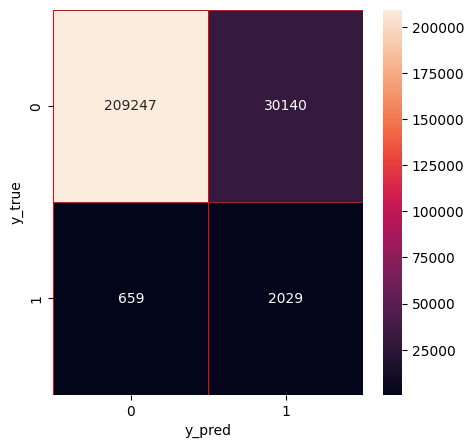

In [36]:
# Plot confusion matrix for test data
y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


## 3.3 Random Forest

In [37]:
# Define the grid search parameters
rf = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [10, 20, 30, 40, 50, 70, 90, 120]}
clf = GridSearchCV(rf, parameters, scoring='f1')
gs = clf.fit(x_train, y_train)
print(f"Best Params : {gs.best_params_}")
print(f"Best Score : {gs.best_score_}")


Best Params : {'max_depth': 120, 'n_estimators': 200}
Best Score : 0.9157608750187689


In [38]:
# Training on best parameters
rf = RandomForestClassifier(n_estimators=gs.best_params_[
                            'n_estimators'], max_depth=gs.best_params_['max_depth'])
rf.fit(x_train, y_train)

# Storing predictions for train,cv and test data
y_pred_train = rf.predict(x_train)
y_prob_train = rf.predict_proba(x_train)[:, 1]

y_pred_valid = rf.predict(x_cv)
y_prob_valid = rf.predict_proba(x_cv)[:, 1]

y_pred_test = rf.predict(x_test)
y_prob_test = rf.predict_proba(x_test)[:, 1]

# Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_train), 4)
        rs = round(recall_score(y_train, y_pred_train), 4)
        ps = round(average_precision_score(y_train, y_prob_train), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_valid), 4)
        rs = round(recall_score(y_cv, y_pred_valid), 4)
        ps = round(average_precision_score(y_cv, y_prob_valid), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])

print(x)


+----------+---------------+----------+--------+-----------+
| Data Set |     Model     | Accuracy | Recall | Precision |
+----------+---------------+----------+--------+-----------+
|  Train   | Random Forest |  0.9977  | 0.9986 |   0.9999  |
|    CV    | Random Forest |  0.9163  | 0.9486 |   0.9678  |
|   Test   | Random Forest |  0.8993  | 0.8013 |   0.1734  |
+----------+---------------+----------+--------+-----------+


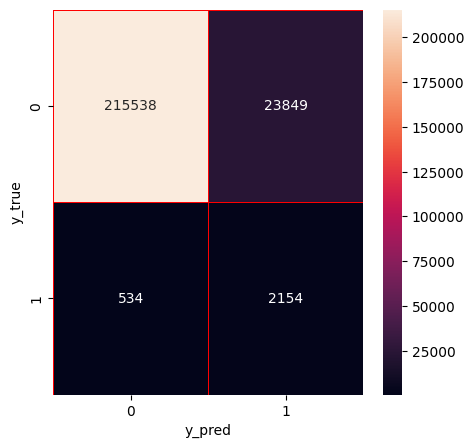

In [39]:
# Plot confusion matrix for test data
y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


## 3.4 Light GBM

In [40]:
# Define the grid search parameters
lgbm = LGBMClassifier()
parameters = {'n_estimators': [10, 100, 200, 500],
              'max_depth': [5, 7, 10, 20, 30, 50]}
clf = GridSearchCV(lgbm, parameters, n_jobs=-1, scoring='f1')
gs = clf.fit(x_train, np.ravel(y_train))
print(f"Best Params : {gs.best_params_}")
print(f"Best Score : {gs.best_score_}")


[LightGBM] [Info] Number of positive: 10164, number of negative: 10163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123341
[LightGBM] [Info] Number of data points in the train set: 20327, number of used features: 498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000098
[LightGBM] [Info] Start training from score 0.000098
Best Params : {'max_depth': 30, 'n_estimators': 500}
Best Score : 0.9201436043563735


In [41]:
# Training on best parameters
lgbm = LGBMClassifier(n_estimators=gs.best_params_[
                      'n_estimators'], max_depth=gs.best_params_['max_depth'], n_jobs=-1)
lgbm.fit(x_train, y_train)

# Storing predictions for train,cv and test data
y_pred_tr = lgbm.predict(x_train)
y_prob_tr = lgbm.predict_proba(x_train)[:, 1]

y_pred_cv = lgbm.predict(x_cv)
y_prob_cv = lgbm.predict_proba(x_cv)[:, 1]

y_pred_test = lgbm.predict(x_test)
y_prob_test = lgbm.predict_proba(x_test)[:, 1]

# Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_tr), 4)
        rs = round(recall_score(y_train, y_pred_tr), 4)
        ps = round(average_precision_score(y_train, y_prob_tr), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_cv), 4)
        rs = round(recall_score(y_cv, y_pred_cv), 4)
        ps = round(average_precision_score(y_cv, y_prob_cv), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])

print(x)


[LightGBM] [Info] Number of positive: 10164, number of negative: 10163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123341
[LightGBM] [Info] Number of data points in the train set: 20327, number of used features: 498
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500025 -> initscore=0.000098
[LightGBM] [Info] Start training from score 0.000098
+----------+-----------+----------+--------+-----------+
| Data Set |   Model   | Accuracy | Recall | Precision |
+----------+-----------+----------+--------+-----------+
|  Train   | Light GBM |  0.994   | 0.9963 |   0.9998  |
|    CV    | Light GBM |  0.9203  | 0.9513 |   0.9607  |
|   Test   | Light GBM |  0.9084  | 0.7883 |   0.2107  |
+----------+-----------+----------+--------+-----------+


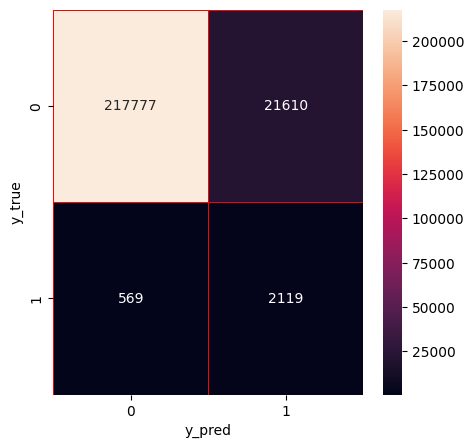

In [42]:
# Plot confusion matrix for test data
y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


##### Considering both Accuracy and Recall we are moving ahead with Random Forest.

## 3.5 Saving the best performed model and features

In [44]:
# Saving model using joblib
joblib.dump(rf, open('D:/Backorder Prediction/backorder-prediction/backorder_best_model.pkl', 'wb'))

# Saving best feature columns for prediction
joblib.dump(x_test.columns, open('D:/Backorder Prediction/backorder-prediction/test_best_feat.pkl', 'wb'))

# Saving the test data
x_test.to_csv('D:/Backorder Prediction/backorder-prediction/test_dataset/Test_Dataset.csv')

# #Saving the standardization object instance
joblib.dump(sc, open('D:/Backorder Prediction/backorder-prediction/sc.pkl', 'wb'))


In [45]:
testing = pd.read_csv('D:/Backorder Prediction/backorder-prediction/test_dataset/Test_Dataset.csv')
testing.drop(['Unnamed: 0'], axis=1, inplace=True)


## 3.6 Creating a Pie Chart

In [47]:
# Creating a Pie Chart
filename = 'D:/Backorder Prediction/backorder-prediction/app/backorder/model/backorder_best_model.pkl'
model = joblib.load(filename)


def create_piechart(df):
    new = df[5:6:]

    predictions = model.predict_proba(new)
    arr = np.array(predictions)
    print(predictions)

    labels = ['No', 'Yes']
    # _colors = ['#FFC107', '#03A9F4']  # custom colors for the pie chart
    _colors = ['gold', 'lightskyblue']
    explode = (0.1, 0)  # explode 1st slice

    fig, ax = plt.subplots(facecolor='None')
    ax.pie(arr[0], explode=explode, labels=labels, colors=_colors,
           autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')

    fig.set_facecolor('None')
    # plt.savefig('images/piechart.png')  # save the figure with no padding and no background
    plt.show()


create_piechart(testing)


ValueError: Number of features of the model must match the input. Model n_features_ is 497 and input n_features is 498

In [ ]:
testing = pd.concat([testing, y_test], axis=1)
testing


In [ ]:
# Performance chart
data = testing.copy()
fig, ax = plt.subplots(facecolor='None')
plt.scatter(data['perf_6_month_avg'], data['perf_12_month_avg'],
            c=data['went_on_backorder'], cmap='coolwarm')
plt.xlabel('Performance (6 month average)')
plt.ylabel('Performance (12 month average)')
plt.title('Relationship between Performance and Backorders')
plt.colorbar(label='Likelihood of Backorders')
fig.set_facecolor('None')  # set the background color of the figure to None
# plt.savefig('images/performance.png')  # save the figure with no padding
plt.show()


In [ ]:
# Forecast and Sales chart
def forecast_sales(data, forcast, sales):
    for i in range(len(sales)):
        fig, ax = plt.subplots(facecolor='None')

        # create a scatter plot of forecast vs. backorders
        plt.scatter(data[forcast[i]], data['went_on_backorder'],
                    color='blue', label='forecast')

        # create a scatter plot of sales vs. backorders
        plt.scatter(data[sales[i]], data['went_on_backorder'],
                    color='red', label='sales')

        # set axis labels and title
        plt.xlabel('Forecast/Sales')
        plt.ylabel('Backorder')
        plt.title(
            'Relationship between Backorder and Forecast/Sales' + sales[i][5:])

        # show the legend
        plt.legend()

        # display the plot
        fig.set_facecolor('None')
        # save the figure with no padding and no background
        plt.savefig('images/' + sales[i][5:] + 'sales.png')
        plt.show()


forcast_col = ['forecast_3_month', 'forecast_6_month', 'forecast_9_month']
sales_col = ['sales_3_month', 'sales_6_month', 'sales_9_month']
forecast_sales(testing, forcast_col, sales_col)
